In [103]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import random

In [104]:
def f(x):
    return 3*x**2 - 4*x +5

In [105]:
f(3.0)

20.0

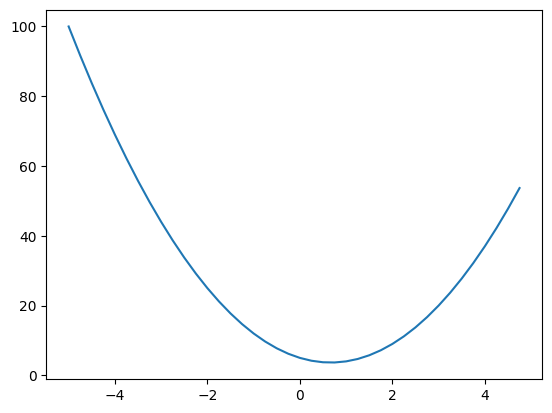

In [106]:
xs = np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [107]:
h = 0.00000000001
x = 2/3
(f(x+h)-f(x))/h

0.0

In [108]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c 
print(d)

4.0


In [109]:
h=0.00000001
#inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c+=h
d2 = a*b +c

print('d1: ',d1)
print("d2: ",d2)
print("slope: ",(d2-d1)/h)

d1:  4.0
d2:  4.000000010000001
slope:  1.000000082740371


In [110]:
class Value:
    def __init__(self,data,_children=(),_op='',label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label=label
    def __repr__(self):
        return f"value(data={self.data})"
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
    def __sub__(self,other):
        return self + (-other)
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self,other):
        return self*other
    def __truediv__(self,other):
        return self*other**-1
    
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad +=other*self.data ** (other-1) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad = (x-1)*out.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x=self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward=_backward
        return out  
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
        
a= Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
d=a*b+c # equivalent to a.__mul__(b).__add__(c)
f = Value(-2.0,label='f')
L = d*f;L.label='L'
L

value(data=-8.0)

In [111]:
a = Value(2.0)
b = Value(4.0)
b-a

value(data=2.0)

In [112]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [113]:
a.data+=0.01*a.grad
b.data+=0.01*b.grad
c.data+=0.01*c.grad
f.data+=0.01*f.grad

e = a*b
d = e+c
L=d*f

print(L.data)

-36.0


In [114]:
d._prev

{value(data=10.0), value(data=8.0)}

In [115]:
d._op

'+'

In [116]:
def lol():
    h=0.000001
    a= Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    d=a*b+c # equivalent to a.__mul__(b).__add__(c)
    f = Value(-2.0,label='f')
    L = d*f;L.label='L'
    L1=L.data


    a= Value(2.0,label='a')
    b = Value(-3.0+h,label='b')
    c = Value(10.0,label='c')
    d=a*b+c # equivalent to a.__mul__(b).__add__(c)
    #d.data+=h
    f = Value(-2.0,label='f')
    L = d*f;L.label='L'
    L2=L.data

    print((L2-L1)/h)
lol()

-4.000000000559112


In [117]:
# inputs x1 x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.88137358,label='b')
# x1w1+x2w2+b
x1w1 = x1*w1;x1w1.label = 'x1*w1'
x2w2 = x2*w2;x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2;x1w1x2w2.label = "x1w1+x2w2"

n = x1w1x2w2+b;n.label = 'n'
o=n.tanh();o.label='o'


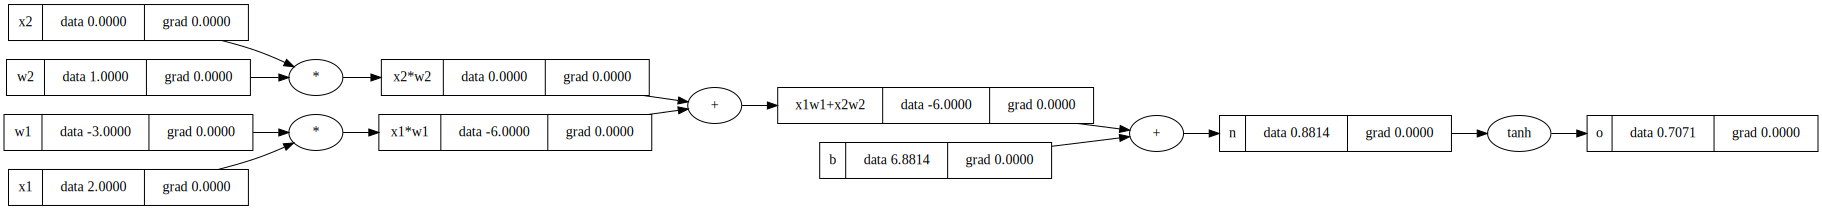

In [118]:
draw_dot(o)

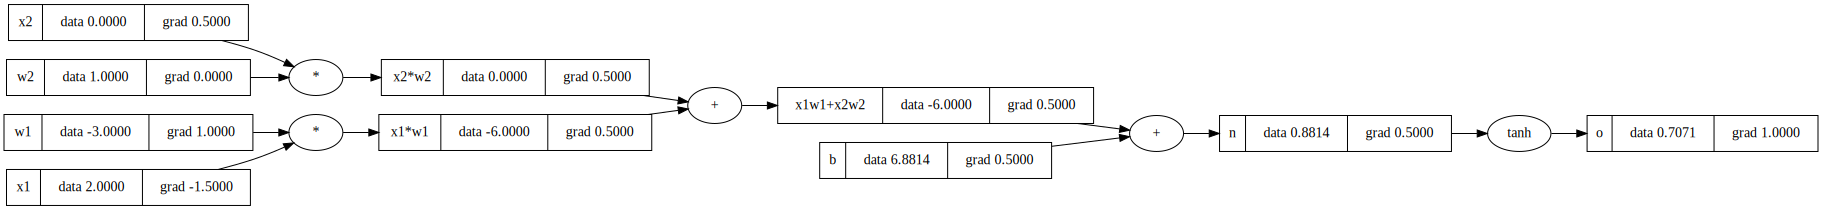

In [119]:
o.backward()
draw_dot(o)

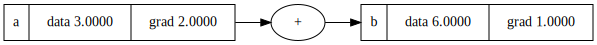

In [120]:
# a bad bug
a = Value(3.0,label='a')
b = a+a;b.label = 'b'
b.backward()
draw_dot(b)

In [121]:
o.grad = 1.0 
o._backward()

In [122]:
n._backward()

In [123]:
b._backward()

In [124]:
x1w1x2w2._backward()

In [125]:
x2w2._backward()
x1w1._backward()

In [126]:
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad 

In [127]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


In [128]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [129]:
x1w1x2w2.grad=0.5
b.grad=0.5

In [130]:
n.grad=0.5

In [131]:
o.grad = 1.0

In [132]:
1-o.data**2

0.5000000049635664

In [133]:
# o = tanh(n)
# d0/dn = 1-tanh^2(n)

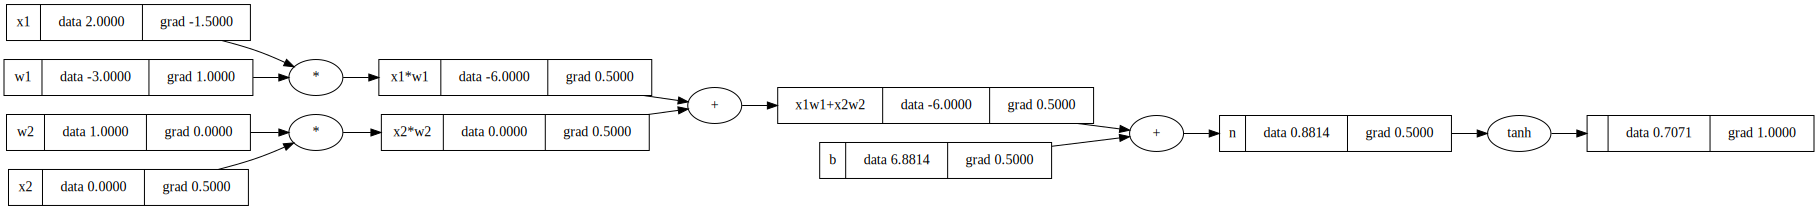

In [134]:
# inputs x1 x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1w1+x2w2+b
x1w1 = x1*w1;x1w1.label = 'x1*w1'
x2w2 = x2*w2;x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2;x1w1x2w2.label = "x1w1+x2w2"

n = x1w1x2w2+b;n.label = 'n'
#x=(2*n).exp()
#o=(x-1)/(x+1)
o=n.tanh()
o.backward()
draw_dot(o)


In [175]:
class Neuron:
    def __init__(self,nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        # w*x+b
        act=self.b
        for wi,xi in zip(self.w,x):
            act+=(wi*xi)
        #print(act)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] 

x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

value(data=-0.9301083644884329)

In [178]:
n.parameters()

[value(data=-0.582296988351698),
 value(data=0.524806138252665),
 value(data=-0.770675916744795),
 value(data=0.3125112591490573),
 value(data=-0.5920151972144201),
 value(data=0.478717290500253),
 value(data=-0.10687977406253157),
 value(data=-0.05169539806225831),
 value(data=-0.7045815367670341),
 value(data=0.23785468648607222),
 value(data=-0.9322957583566596),
 value(data=0.02202612303447604),
 value(data=-0.6837619427426116),
 value(data=0.8328046559499467),
 value(data=-0.8994640539932861),
 value(data=0.5210255473311278),
 value(data=-0.4092025669674768),
 value(data=-0.7514977160243947),
 value(data=-0.37816227449037143),
 value(data=0.2991565352056844),
 value(data=-0.4208696290179499),
 value(data=0.7900343683688265),
 value(data=0.030042901744526285),
 value(data=0.6812515842156559),
 value(data=-0.566944618074239),
 value(data=0.43250675347497225),
 value(data=-0.46063157404377164),
 value(data=-0.6907755064787293),
 value(data=0.20066724330291774),
 value(data=-0.9241324

In [180]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0,-1.0,-1.0,1.0]
ypred = [n(x) for x in xs]
ypred

[value(data=-0.9301083644884329),
 value(data=-0.3343167374522723),
 value(data=-0.0599405734000496),
 value(data=-0.9484360747361241)]

In [181]:
loss = Value(0)
for ygt,yout in zip(ys,ypred):
    loss+=(yout-ygt)**2
loss/=len(ypred)
print(loss) 


value(data=2.2121418418942356)


In [184]:
loss.backward()

In [185]:
n.layers[0].neurons[0].w[0].grad

0.6016405406967206

In [ ]:
draw_dot(loss)

In [187]:
n.layers[0].neurons[0].w[0].data

-0.5883133937586652

In [197]:
for p in n.parameters():
    p.data += -0.01 * p.grad


In [192]:
n.layers[0].neurons[0].w[0].data

-0.6003462045725997

Full training loop implementation

In [209]:
n=MLP(3,[4,4,1])
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0,-1.0,-1.0,1.0]
for iters in range(5000):
    ypred = [n(x) for x in xs]
    loss = Value(0)
    for ygt,yout in zip(ys,ypred):
        loss+=(yout-ygt)**2
    loss/=len(ypred)
    loss.backward()
    print(loss.data)
    if(loss.data < 0.000001):
        break
    for p in n.parameters():
        p.data += -0.1 * p.grad
        p.grad=0
    


1.535794030894484
1.3227759184762484
1.0729542588544756
0.775709443784646
0.7050676740174975
0.659158505577607
0.49449173851005357
0.35399314372663654
0.27554253324644035
0.22673238146393437
0.18535038914043633
0.1570308768500734
0.13249475648777143
0.11261790967798052
0.09745054370633649
0.08467113375684852
0.07390108654834139
0.0650094879220535
0.057900235795043865
0.051900952343922634
0.04617190791843078
0.03851606757614268
0.035807904274028496
0.032379653700052094
0.028765529645118453
0.026611223496871797
0.024719332680774093
0.023042594729232653
0.021762299661364334
0.020505002681413267
0.019402507218135762
0.018416101609292062
0.01750925000999134
0.016701984534648353
0.015948020753345615
0.015165413407092891
0.01455347841984022
0.013979583346995127
0.013482280359429062
0.012908000909642142
0.012405479358670746
0.012002910593626431
0.011599532683491494
0.01123258701695934
0.01087808373432372
0.010521644492776526
0.010196077468227496
0.009907083267169948
0.009636888077251328
0.0093

In [207]:
ypred

[value(data=0.9824689099738367),
 value(data=-0.9795429735574859),
 value(data=-0.9732690456885107),
 value(data=0.9811279637247716)]

In [208]:
n.parameters()

[value(data=-0.018822244003671613),
 value(data=-0.7367733496234948),
 value(data=1.543808958151053),
 value(data=0.825323579390505),
 value(data=0.5995823850286838),
 value(data=-0.6085141836298992),
 value(data=0.8610926747953429),
 value(data=-0.029594613846185662),
 value(data=0.5594106757716163),
 value(data=-0.6645763217171292),
 value(data=0.3754081340393616),
 value(data=0.35176677583192273),
 value(data=0.8526722351402437),
 value(data=0.25582314915037985),
 value(data=0.5234852572537261),
 value(data=0.36987865425591204),
 value(data=1.014199270339495),
 value(data=-0.4943420305567682),
 value(data=0.7090490256544683),
 value(data=0.869904766738374),
 value(data=-0.6974746055482468),
 value(data=-0.30223065468484234),
 value(data=0.8046605315523685),
 value(data=-0.007462709709674473),
 value(data=0.4566785081450512),
 value(data=0.7047325525856178),
 value(data=1.254484672501258),
 value(data=0.546682290492046),
 value(data=-0.6788327453001293),
 value(data=1.097356001028228